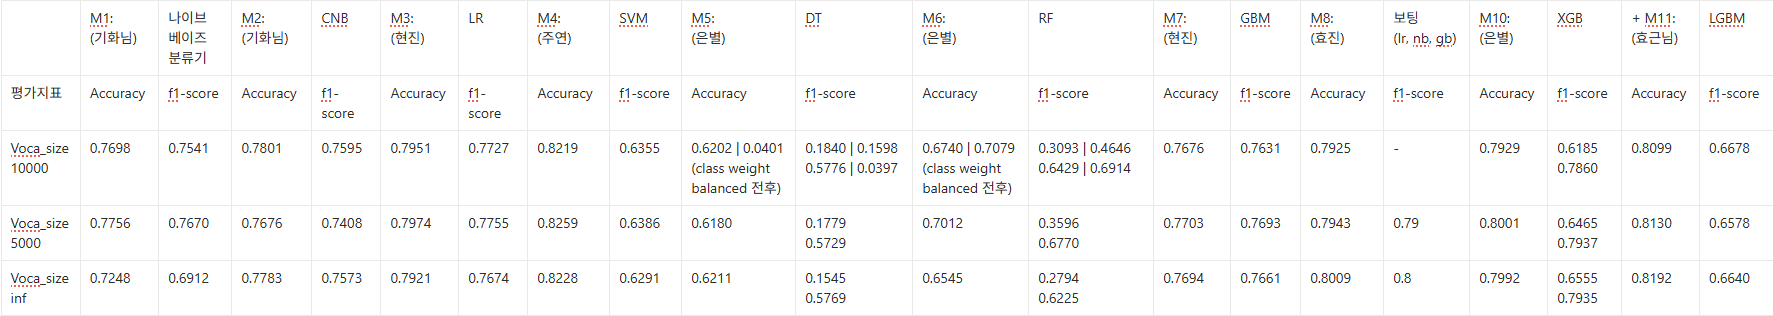

회고:
본 실험에서는 SVM이 가장 높은 Accuracy를 기록했으나, 클래스 불균형을 고려한 f1-score 기준에서는 LGBM이 vocabulary size 변화에도 가장 안정적이고 우수한 성능을 보인 최적의 모델로 판단된다

In [1]:
from tensorflow.keras.datasets import reuters
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
# 이부분에있는 num_words를 5000과 다른방법으로 바꿔보세요~

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [3]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [4]:
index_to_word = { index+3 : word for word, index in word_index.items() }
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [5]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [6]:
decoded_test = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded_test.append(t)

x_test = decoded_test
print(len(x_test))

2246


In [7]:
# 벡터화 DTM, TF-idf 방법
dtmvector = CountVectorizer()

tfidf_transformer = TfidfTransformer()

x_train_dtm = dtmvector.fit_transform(x_train)
x_test_dtm= dtmvector.transform(x_test)

x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

In [8]:
x_train_tfidf.shape

(8982, 26506)

In [9]:
x_test_tfidf.shape

(2246, 26506)

In [10]:
x_train[3]

"<sos> the farmers home administration the u s agriculture department's farm lending arm could lose about seven billion dlrs in outstanding principal on its severely delinquent borrowers or about one fourth of its farm loan portfolio the general accounting office gao said in remarks prepared for delivery to the senate agriculture committee brian crowley senior associate director of gao also said that a preliminary analysis of proposed changes in fmha's financial eligibility standards indicated as many as one half of fmha borrowers who received new loans from the agency in 1986 would be ineligible under the proposed system the agency has proposed evaluating applicants' credit using a variety of financial ratios instead of relying solely on cashflow ability senate agriculture committee chairman patrick leahy d vt slammed the proposed eligibility changes telling fmha administrator vance clark at a hearing that they would mark a dramatic shift in the agency's purpose away from being farmer

In [11]:
# TF-idf데이터로 XGBoost 모델 학습하기

# 이친구도 시간좀 걸립니다!

from xgboost import XGBClassifier

# XGBoost 모델 학습
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, eval_metric='mlogloss')
xgb_model.fit(x_train_tfidf, y_train)

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
# 예측
y_pred = xgb_model.predict(x_test_tfidf)

# 평가 지표
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")

✅ Accuracy : 0.7947
✅ F1-score : 0.6458


In [13]:
# TF-idf 데이터로 LightGBM 모델 학습하기
# 이것도 시간 좀 걸립니다!

from lightgbm import LGBMClassifier

# LightGBM 모델 학습
lgbm_model = LGBMClassifier(
    n_estimators=300,
    max_depth=-1,
    learning_rate=0.05,
    num_leaves=31,
    class_weight='balanced',
    random_state=42
)

lgbm_model.fit(x_train_tfidf, y_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=300,
               random_state=42)

In [14]:
# 예측
y_pred = lgbm_model.predict(x_test_tfidf)

# 평가
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")


✅ Accuracy : 0.8112
✅ F1-score : 0.6612


In [15]:
from tensorflow.keras.datasets import reuters
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score

# 단어 인덱스
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = {index+3: word for word, index in word_index.items()}
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token


In [16]:
vocab_settings = {
    "Voca_size 10000": 10000,
    "Voca_size 5000": 5000,
    "Voca_size inf": None
}

for name, num_words in vocab_settings.items():
    print(f"\n===== {name} =====")

    # 데이터 로드
    (x_train, y_train), (x_test, y_test) = reuters.load_data(
        num_words=num_words,
        test_split=0.2
    )

    # 디코딩
    x_train = [' '.join([index_to_word.get(i, '<unk>') for i in x]) for x in x_train]
    x_test = [' '.join([index_to_word.get(i, '<unk>') for i in x]) for x in x_test]

    # 벡터화 (inf여도 feature는 제한)
    max_features = num_words if num_words is not None else 10000

    dtmvector = CountVectorizer(
        max_features=max_features,
        min_df=5,
        max_df=0.9
    )
    tfidf = TfidfTransformer()

    x_train_dtm = dtmvector.fit_transform(x_train)
    x_test_dtm = dtmvector.transform(x_test)

    x_train_tfidf = tfidf.fit_transform(x_train_dtm)
    x_test_tfidf = tfidf.transform(x_test_dtm)

    # LGBM
    lgbm_model = LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        class_weight='balanced',
        random_state=42
    )

    lgbm_model.fit(x_train_tfidf, y_train)

    # 평가
    y_pred = lgbm_model.predict(x_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"✅ Accuracy : {acc:.4f}")
    print(f"✅ F1-score : {f1:.4f}")



===== Voca_size 10000 =====
✅ Accuracy : 0.8099
✅ F1-score : 0.6678

===== Voca_size 5000 =====
✅ Accuracy : 0.8130
✅ F1-score : 0.6578

===== Voca_size inf =====
✅ Accuracy : 0.8192
✅ F1-score : 0.6640


In [28]:
# 딥러닝과 비교

In [25]:
import numpy as np
from tensorflow.keras.datasets import reuters
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping



In [18]:
import numpy as np

classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, weights))


In [19]:
inputs = Input(shape=(x_train_tfidf.shape[1],))

x = Dense(512, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(46, activation='softmax')(x)

dense_model = Model(inputs=inputs, outputs=outputs)

dense_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

dense_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9101)]            0         
_________________________________________________________________
dense (Dense)                (None, 512)               4660224   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 46)                5934      
Total params: 4,731,822
Trainable params: 4,731,822
Non-trainable params: 0
___________________________________________________

In [23]:
from sklearn.model_selection import train_test_split

# train / val split
x_tr, x_val, y_tr, y_val = train_test_split(
    x_train_tfidf,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

# 🔥 핵심: sparse index 정렬
x_tr.sort_indices()
x_val.sort_indices()
x_test_tfidf.sort_indices()

# 학습
dense_model.fit(
    x_tr,
    y_tr,
    epochs=20,
    batch_size=32,
    validation_data=(x_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)



Epoch 1/20


/opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 512), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


225/225 [==============================] - 12s 7ms/step - loss: 3.4664 - accuracy: 0.5665 - val_loss: 1.7459 - val_accuracy: 0.7835
Epoch 2/20
225/225 [==============================] - 1s 6ms/step - loss: 1.6728 - accuracy: 0.7478 - val_loss: 1.0751 - val_accuracy: 0.7997
Epoch 3/20
225/225 [==============================] - 1s 6ms/step - loss: 0.6252 - accuracy: 0.8294 - val_loss: 0.9233 - val_accuracy: 0.8075
Epoch 4/20
225/225 [==============================] - 1s 6ms/step - loss: 0.3114 - accuracy: 0.8797 - val_loss: 0.8533 - val_accuracy: 0.8242
Epoch 5/20
225/225 [==============================] - 1s 6ms/step - loss: 0.2026 - accuracy: 0.9054 - val_loss: 0.7887 - val_accuracy: 0.8331
Epoch 6/20
225/225 [==============================] - 1s 6ms/step - loss: 0.1649 - accuracy: 0.9255 - val_loss: 0.8627 - val_accuracy: 0.8214
Epoch 7/20
225/225 [==============================] - 1s 6ms/step - loss: 0.1536 - accuracy: 0.9311 - val_loss: 0.8297 - val_accuracy: 0.8264
Epoch 8/20
225/2

In [24]:
y_pred_proba = dense_model.predict(x_test_tfidf)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")


✅ Accuracy : 0.8183
✅ F1-score : 0.6688


In [26]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = {index+3: word for word, index in word_index.items()}
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token


In [27]:
vocab_settings = {
    "Voca_size 10000": 10000,
    "Voca_size 5000": 5000,
    "Voca_size inf": None
}

results_dense = {}

for name, num_words in vocab_settings.items():
    print(f"\n===== {name} =====")

    # 데이터 로드
    (x_train, y_train), (x_test, y_test) = reuters.load_data(
        num_words=num_words,
        test_split=0.2
    )

    # 디코딩
    x_train = [' '.join([index_to_word.get(i, '<unk>') for i in x]) for x in x_train]
    x_test = [' '.join([index_to_word.get(i, '<unk>') for i in x]) for x in x_test]

    # TF-IDF (inf라도 feature 제한)
    max_features = num_words if num_words is not None else 10000

    dtmvector = CountVectorizer(
        max_features=max_features,
        min_df=5,
        max_df=0.9
    )
    tfidf = TfidfTransformer()

    x_train_dtm = dtmvector.fit_transform(x_train)
    x_test_dtm = dtmvector.transform(x_test)

    x_train_tfidf = tfidf.fit_transform(x_train_dtm)
    x_test_tfidf = tfidf.transform(x_test_dtm)

    # sparse index 정렬
    x_train_tfidf.sort_indices()
    x_test_tfidf.sort_indices()

    # train / val split
    x_tr, x_val, y_tr, y_val = train_test_split(
        x_train_tfidf,
        y_train,
        test_size=0.2,
        random_state=42,
        stratify=y_train
    )

    x_tr.sort_indices()
    x_val.sort_indices()

    # class weight
    classes = np.unique(y_tr)
    weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y_tr
    )
    class_weight_dict = dict(zip(classes, weights))

    # Dense 모델
    inputs = Input(
        shape=(x_train_tfidf.shape[1],),
        sparse=True
    )

    x = Dense(512, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(46, activation='softmax')(x)

    dense_model = Model(inputs=inputs, outputs=outputs)

    dense_model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    # 학습
    dense_model.fit(
        x_tr,
        y_tr,
        epochs=20,
        batch_size=32,
        validation_data=(x_val, y_val),
        class_weight=class_weight_dict,
        callbacks=[early_stop],
        verbose=0
    )

    # 평가
    y_pred = np.argmax(
        dense_model.predict(x_test_tfidf, verbose=0),
        axis=1
    )

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"✅ Accuracy : {acc:.4f}")
    print(f"✅ F1-score : {f1:.4f}")

    results_dense[name] = (acc, f1)



===== Voca_size 10000 =====


/opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/dense_3/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_1/dense_3/embedding_lookup_sparse/Reshape:0", shape=(None, 512), dtype=float32), dense_shape=Tensor("gradient_tape/model_1/dense_3/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


✅ Accuracy : 0.8108
✅ F1-score : 0.6439

===== Voca_size 5000 =====


/opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_2/dense_6/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_2/dense_6/embedding_lookup_sparse/Reshape:0", shape=(None, 512), dtype=float32), dense_shape=Tensor("gradient_tape/model_2/dense_6/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


✅ Accuracy : 0.8077
✅ F1-score : 0.6459

===== Voca_size inf =====


/opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_3/dense_9/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_3/dense_9/embedding_lookup_sparse/Reshape:0", shape=(None, 512), dtype=float32), dense_shape=Tensor("gradient_tape/model_3/dense_9/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


✅ Accuracy : 0.8077
✅ F1-score : 0.6513


TF-IDF 기반의 고차원 희소 데이터에서는 트리 기반 모델인 LGBM이 특징을 더 효율적으로 활용하였다. LGBM은 클래스 불균형에 대해 class_weight를 적용함으로써 안정적인 분류 성능을 보였다. 반면 Dense 모델은 입력 차원이 커질수록 학습 효율이 저하되는 경향을 보였다. Vocabulary Size가 증가함에 따라 희귀 단어로 인한 노이즈 영향이 Dense 모델에서 더 크게 나타났다. 이러한 이유로 본 실험에서는 딥러닝 모델보다 LGBM이 데이터 특성에 더 적합한 성능을 보였다.